In [566]:
import torch
import cv2
import matplotlib.pyplot as plt
import os
import tarfile
import collections
from torchvision.datasets.vision import VisionDataset
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision.datasets.utils import download_url, check_integrity, verify_str_arg
from torchvision import transforms 
import numpy as np

In [567]:
# Note: Copy from Pytorch github
DATASET_YEAR_DICT = {
    '2012': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar',
        'filename': 'VOCtrainval_11-May-2012.tar',
        'md5': '6cd6e144f989b92b3379bac3b3de84fd',
        'base_dir': os.path.join('VOCdevkit', 'VOC2012')
    },
    '2011': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2011/VOCtrainval_25-May-2011.tar',
        'filename': 'VOCtrainval_25-May-2011.tar',
        'md5': '6c3384ef61512963050cb5d687e5bf1e',
        'base_dir': os.path.join('TrainVal', 'VOCdevkit', 'VOC2011')
    },
    '2010': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar',
        'filename': 'VOCtrainval_03-May-2010.tar',
        'md5': 'da459979d0c395079b5c75ee67908abb',
        'base_dir': os.path.join('VOCdevkit', 'VOC2010')
    },
    '2009': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar',
        'filename': 'VOCtrainval_11-May-2009.tar',
        'md5': '59065e4b188729180974ef6572f6a212',
        'base_dir': os.path.join('VOCdevkit', 'VOC2009')
    },
    '2008': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar',
        'filename': 'VOCtrainval_11-May-2012.tar',
        'md5': '2629fa636546599198acfcfbfcf1904a',
        'base_dir': os.path.join('VOCdevkit', 'VOC2008')
    },
    '2007': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar',
        'filename': 'VOCtrainval_06-Nov-2007.tar',
        'md5': 'c52e279531787c972589f7e41ab4ae64',
        'base_dir': os.path.join('VOCdevkit', 'VOC2007')
    },
    '2007-test': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar',
        'filename': 'VOCtest_06-Nov-2007.tar',
        'md5': 'b6e924de25625d8de591ea690078ad9f',
        'base_dir': os.path.join('VOCdevkit', 'VOC2007')
    }
}






class VOCDetection(VisionDataset):
    """`Pascal VOC <http://host.robots.ox.ac.uk/pascal/VOC/>`_ Detection Dataset.

    Args:
        root (string): Root directory of the VOC Dataset.
        year (string, optional): The dataset year, supports years 2007 to 2012.
        image_set (string, optional): Select the image_set to use, ``train``, ``trainval`` or ``val``
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
            (default: alphabetic indexing of VOC's 20 classes).
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, required): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version.
    """

    def __init__(self,
                 root,
                 year='2012',
                 image_set='train',
                 download=False,
                 transform=None,
                 target_transform=None,
                 transforms=None):
        super(VOCDetection, self).__init__(root, transforms, transform, target_transform)
        self.year = year
        if year == "2007" and image_set == "test":
            year = "2007-test"
        self.url = DATASET_YEAR_DICT[year]['url']
        self.filename = DATASET_YEAR_DICT[year]['filename']
        self.md5 = DATASET_YEAR_DICT[year]['md5']
        valid_sets = ["train", "trainval", "val"]
        if year == "2007-test":
            valid_sets.append("test")
        self.image_set = verify_str_arg(image_set, "image_set", valid_sets)

        base_dir = DATASET_YEAR_DICT[year]['base_dir']
        voc_root = os.path.join(self.root, base_dir)
        image_dir = os.path.join(voc_root, 'JPEGImages')
        annotation_dir = os.path.join(voc_root, 'Annotations')

        if download:
            download_extract(self.url, self.root, self.filename, self.md5)

        if not os.path.isdir(voc_root):
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        splits_dir = os.path.join(voc_root, 'ImageSets/Main')

        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')

        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
        #self.images, self.annotations = self.filter_img(self.images, self.annotations)
        assert (len(self.images) == len(self.annotations))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is a dictionary of the XML tree.
        """
        img = cv2.imread(self.images[index])[..., ::-1].astype(np.float)
        target = self.parse_voc_xml(
            ET.parse(self.annotations[index]).getroot())

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


    def __len__(self):
        return len(self.images)
    
    def filter_img(self, images, annotations):
               
        check_list = [self.check_cat(self.parse_voc_xml(ET.parse( annot ).getroot())) for annot in annotations]
        check_list = np.array(check_list)
        images = np.array(images)[check_list]
        annotations = np.array(annotations)[check_list]
        return images, annotations
        
        
        
    def check_cat(self, target):
        return target['annotation']['object'][0]['name'] == 'cat' 
        

    def parse_voc_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == 'annotation':
                def_dic['object'] = [def_dic['object']]
            voc_dict = {
                node.tag:
                    {ind: v[0] if len(v) == 1 else v
                     for ind, v in def_dic.items()}
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict



def download_extract(url, root, filename, md5):
    download_url(url, root, filename, md5)
    with tarfile.open(os.path.join(root, filename), "r") as tar:
        tar.extractall(path=root)

In [588]:
class Compose():
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, labels=None):
        for t in self.transforms:
            img, labels = t(img, labels)
        return img, labels
    
class ToTensor():
    def __call__(self, src, label):
        src = src.transpose(2, 0, 1)/255
        return torch.Tensor(src), (label)

class ConvertLabel():
    def __call__(self, src, label):
        target = []
        
        shape = src.shape
        
        for elem in label['annotation']['object']:
            name = cls2num[elem['name']]
            bbox = elem['bndbox']
            ymin, ymax = int(bbox['ymin']), int(bbox['ymax']) 
            xmin, xmax = int(bbox['xmin']), int(bbox['xmax'])
            target.append([ymin/shape[0], ymax/shape[0], xmin/shape[1], xmax/shape[1], name])
        return src, np.array(target)
    
class ToSegmentation():
    def __call__(self, src, label):
        gt = np.zeros(shape=src.shape[:2])
        for elem in label['annotation']['object']:
            name = cls2num[elem['name']]
            bbox = elem['bndbox']
            ymin, ymax = int(bbox['ymin']), int(bbox['ymax']) 
            xmin, xmax = int(bbox['xmin']), int(bbox['xmax'])
            
            gt[ymin:ymax, xmin:xmax] = 1 #name 
        return src, gt

In [589]:
cls2num = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4, 'bus':5, 
           'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10, 'dog':11, 'horse':12, 
           'motorbike':13, 'person':14, 'pottedplant':15, 'sheep':16, 'sofa':17, 
           'train':18, 'tvmonitor':19}

In [590]:
transforms_set = Compose([
    ToSegmentation(),
    #ConvertLabel(),
    ToTensor()]
)

imagenet_data = VOCDetection(r'../Datasets/', transforms=transforms_set)
data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=1,
                                          shuffle=True, num_workers=0)

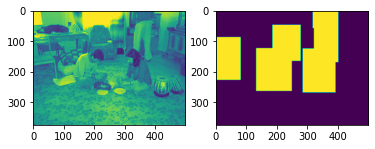

In [592]:
cls_dict = {}
for idx, data in enumerate(data_loader):
    plt.figure()
    plt.subplot(121)
    plt.imshow(data[0][0,0])
    plt.subplot(122)
    plt.imshow(data[1][0])
    break

In [594]:
def get_roi(src, bboxs, idx=0):
    bbox = bboxs[idx]
    shape = src.shape
    print((bbox[0]*shape[0]))
    return src[int(bbox[0]*shape[0]):int(bbox[1]*shape[0]),int(bbox[2]*shape[1]):int(bbox[3]*shape[1])]